In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-o7shgg33
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-o7shgg33
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=cfd25c126bdc4b7013005cda9df07d0a4790734f93087afdf24932844f9cf178
  Stored in directory: /tmp/pip-ephem-wheel-cache-8xp624ew/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [ ]:
# Reference https://albumentations.ai/docs/autoalbument/examples/cifar10/

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1,
                        min_height=16, min_width=16,
                        fill_value=mean, mask_fill_value = None),
        A.Normalize(mean, std),
        A.ToGray(p=0.3),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean, std),
        ToTensorV2(),
    ]
)

trainset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transform)

testloader =torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 frog truck   car  ship


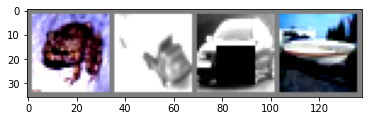

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
from model import Net

In [ ]:
!pip install torchsummary
from torchsummary import summary

model = Net().to(device)  # Create model
summary(model, input_size=(3, 32, 32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 32, 32]           9,248
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
        Dropout2d-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
           Conv2d-14           [-1, 32,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Train and Test functions

In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
# for epoch in range(2):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs
#         inputs, labels = data

#         inputs, labels = inputs.to(device), labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

#model = Net().to(device)
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = OneCycleLR(optimizer, max_lr=0.1,epochs=100,steps_per_epoch=len(trainloader))

for epoch in range(0, 100):
    print(f"Epoch {epoch}")
    # if(epoch % 4 == 0):
    #   lr = lr/10
    #   optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    #if(epoch==25):
    #  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)

    #if(epoch==40):
    #  optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    
    train_loss,train_acc = train(model, device, trainloader, optimizer, epoch)
    #scheduler.step()
    test_loss,test_acc = test(model, device, testloader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0


loss=1.5135619640350342 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.86it/s]


Train set: Average loss: 0.0151, Accuracy: 13867/50000 (27.73%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -1.2799, Accuracy: 3540/10000 (35.40%)

Epoch 1


loss=1.5747276544570923 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.87it/s]


Train set: Average loss: 0.0125, Accuracy: 20625/50000 (41.25%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.1034, Accuracy: 4606/10000 (46.06%)

Epoch 2


loss=1.4772082567214966 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.76it/s]


Train set: Average loss: 0.0113, Accuracy: 23508/50000 (47.02%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.4456, Accuracy: 4884/10000 (48.84%)

Epoch 3


loss=1.1330418586730957 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.59it/s]



Train set: Average loss: 0.0104, Accuracy: 25830/50000 (51.66%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.0921, Accuracy: 5748/10000 (57.48%)

Epoch 4


loss=1.153466820716858 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.83it/s]


Train set: Average loss: 0.0096, Accuracy: 27703/50000 (55.41%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.5943, Accuracy: 6165/10000 (61.65%)

Epoch 5


loss=1.179149866104126 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.85it/s]



Train set: Average loss: 0.0091, Accuracy: 29260/50000 (58.52%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.8030, Accuracy: 6446/10000 (64.46%)

Epoch 6


loss=1.0176994800567627 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.03it/s]



Train set: Average loss: 0.0086, Accuracy: 30410/50000 (60.82%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.2155, Accuracy: 6791/10000 (67.91%)

Epoch 7


loss=1.2467049360275269 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.61it/s]


Train set: Average loss: 0.0081, Accuracy: 31650/50000 (63.30%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.3142, Accuracy: 6976/10000 (69.76%)

Epoch 8


loss=1.0539767742156982 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.47it/s]


Train set: Average loss: 0.0077, Accuracy: 32466/50000 (64.93%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.4366, Accuracy: 7061/10000 (70.61%)

Epoch 9


loss=0.9845185279846191 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.61it/s]


Train set: Average loss: 0.0076, Accuracy: 33019/50000 (66.04%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.7969, Accuracy: 7092/10000 (70.92%)

Epoch 10


loss=0.9761139750480652 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.56it/s]


Train set: Average loss: 0.0073, Accuracy: 33600/50000 (67.20%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.9614, Accuracy: 7297/10000 (72.97%)

Epoch 11


loss=0.95866858959198 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.47it/s]


Train set: Average loss: 0.0071, Accuracy: 34092/50000 (68.18%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.3101, Accuracy: 7196/10000 (71.96%)

Epoch 12


loss=1.0691810846328735 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.66it/s]


Train set: Average loss: 0.0069, Accuracy: 34509/50000 (69.02%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.4161, Accuracy: 7391/10000 (73.91%)

Epoch 13


loss=0.9172168970108032 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.17it/s]


Train set: Average loss: 0.0068, Accuracy: 34774/50000 (69.55%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.2038, Accuracy: 7123/10000 (71.23%)

Epoch 14


loss=0.8136938214302063 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.67it/s]


Train set: Average loss: 0.0066, Accuracy: 35232/50000 (70.46%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.3150, Accuracy: 7468/10000 (74.68%)

Epoch 15


loss=0.9050061106681824 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.22it/s]


Train set: Average loss: 0.0065, Accuracy: 35373/50000 (70.75%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.4312, Accuracy: 7582/10000 (75.82%)

Epoch 16


loss=0.7337912321090698 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.49it/s]



Train set: Average loss: 0.0064, Accuracy: 35749/50000 (71.50%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.7730, Accuracy: 7635/10000 (76.35%)

Epoch 17


loss=0.6924532651901245 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.52it/s]


Train set: Average loss: 0.0063, Accuracy: 35811/50000 (71.62%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.7516, Accuracy: 7704/10000 (77.04%)

Epoch 18


loss=1.0084049701690674 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.28it/s]


Train set: Average loss: 0.0062, Accuracy: 36198/50000 (72.40%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8044, Accuracy: 7676/10000 (76.76%)

Epoch 19


loss=1.0032517910003662 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.23it/s]


Train set: Average loss: 0.0062, Accuracy: 36356/50000 (72.71%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.7810, Accuracy: 7700/10000 (77.00%)

Epoch 20


loss=0.8946622014045715 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.06it/s]


Train set: Average loss: 0.0060, Accuracy: 36666/50000 (73.33%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.8544, Accuracy: 7648/10000 (76.48%)

Epoch 21


loss=0.9840253591537476 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.26it/s]


Train set: Average loss: 0.0060, Accuracy: 36621/50000 (73.24%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.9962, Accuracy: 7627/10000 (76.27%)

Epoch 22


loss=0.5590242147445679 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.43it/s]


Train set: Average loss: 0.0059, Accuracy: 37017/50000 (74.03%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.3010, Accuracy: 7797/10000 (77.97%)

Epoch 23


loss=0.7700374722480774 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.17it/s]


Train set: Average loss: 0.0058, Accuracy: 37036/50000 (74.07%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.3537, Accuracy: 7847/10000 (78.47%)

Epoch 24


loss=0.8213592767715454 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.23it/s]


Train set: Average loss: 0.0058, Accuracy: 37205/50000 (74.41%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.1867, Accuracy: 7835/10000 (78.35%)

Epoch 25


loss=0.7270685434341431 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.07it/s]


Train set: Average loss: 0.0057, Accuracy: 37235/50000 (74.47%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.3782, Accuracy: 7834/10000 (78.34%)

Epoch 26


loss=0.6964948177337646 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.12it/s]


Train set: Average loss: 0.0057, Accuracy: 37395/50000 (74.79%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.1921, Accuracy: 7827/10000 (78.27%)

Epoch 27


loss=0.7758510708808899 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.24it/s]


Train set: Average loss: 0.0056, Accuracy: 37454/50000 (74.91%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.1671, Accuracy: 7895/10000 (78.95%)

Epoch 28


loss=0.7976493239402771 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.22it/s]


Train set: Average loss: 0.0056, Accuracy: 37570/50000 (75.14%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.5557, Accuracy: 7820/10000 (78.20%)

Epoch 29


loss=0.5420539379119873 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.92it/s]


Train set: Average loss: 0.0055, Accuracy: 37693/50000 (75.39%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.4860, Accuracy: 7963/10000 (79.63%)

Epoch 30


loss=0.7379060983657837 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.62it/s]


Train set: Average loss: 0.0055, Accuracy: 37774/50000 (75.55%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7506, Accuracy: 7961/10000 (79.61%)

Epoch 31


loss=0.7871973514556885 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.03it/s]


Train set: Average loss: 0.0054, Accuracy: 38108/50000 (76.22%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6271, Accuracy: 7898/10000 (78.98%)

Epoch 32


loss=0.4608135223388672 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.13it/s]


Train set: Average loss: 0.0054, Accuracy: 37933/50000 (75.87%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.5407, Accuracy: 8010/10000 (80.10%)

Epoch 33


loss=0.7363887429237366 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.81it/s]


Train set: Average loss: 0.0053, Accuracy: 38177/50000 (76.35%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7084, Accuracy: 7963/10000 (79.63%)

Epoch 34


loss=0.6165940761566162 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.18it/s]


Train set: Average loss: 0.0053, Accuracy: 38138/50000 (76.28%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7956, Accuracy: 8007/10000 (80.07%)

Epoch 35


loss=0.8565794825553894 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.55it/s]


Train set: Average loss: 0.0053, Accuracy: 38174/50000 (76.35%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7992, Accuracy: 8053/10000 (80.53%)

Epoch 36


loss=0.7291864156723022 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.82it/s]


Train set: Average loss: 0.0052, Accuracy: 38497/50000 (76.99%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.8835, Accuracy: 8051/10000 (80.51%)

Epoch 37


loss=0.7845923900604248 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.61it/s]


Train set: Average loss: 0.0052, Accuracy: 38458/50000 (76.92%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0432, Accuracy: 8029/10000 (80.29%)

Epoch 38


loss=0.7192932367324829 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.84it/s]


Train set: Average loss: 0.0052, Accuracy: 38505/50000 (77.01%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0583, Accuracy: 8001/10000 (80.01%)

Epoch 39


loss=0.6559441685676575 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.97it/s]


Train set: Average loss: 0.0051, Accuracy: 38567/50000 (77.13%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0318, Accuracy: 8062/10000 (80.62%)

Epoch 40


loss=0.5581668615341187 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.78it/s]


Train set: Average loss: 0.0051, Accuracy: 38761/50000 (77.52%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0773, Accuracy: 8158/10000 (81.58%)

Epoch 41


loss=0.7425942420959473 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.98it/s]


Train set: Average loss: 0.0051, Accuracy: 38679/50000 (77.36%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1937, Accuracy: 7964/10000 (79.64%)

Epoch 42


loss=0.6246102452278137 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.34it/s]


Train set: Average loss: 0.0050, Accuracy: 38818/50000 (77.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1927, Accuracy: 8070/10000 (80.70%)

Epoch 43


loss=0.8380748629570007 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s]


Train set: Average loss: 0.0050, Accuracy: 38808/50000 (77.62%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0086, Accuracy: 8106/10000 (81.06%)

Epoch 44


loss=0.6984265446662903 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 31.05it/s]


Train set: Average loss: 0.0050, Accuracy: 38787/50000 (77.57%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.9470, Accuracy: 8042/10000 (80.42%)

Epoch 45


loss=0.64838045835495 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.55it/s]


Train set: Average loss: 0.0050, Accuracy: 38953/50000 (77.91%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2535, Accuracy: 8048/10000 (80.48%)

Epoch 46


loss=0.521342396736145 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.56it/s]


Train set: Average loss: 0.0049, Accuracy: 38994/50000 (77.99%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1550, Accuracy: 8088/10000 (80.88%)

Epoch 47


loss=0.5209380984306335 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.45it/s]


Train set: Average loss: 0.0050, Accuracy: 39001/50000 (78.00%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2031, Accuracy: 8105/10000 (81.05%)

Epoch 48


loss=0.6104517579078674 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.51it/s]


Train set: Average loss: 0.0049, Accuracy: 39223/50000 (78.45%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0010, Accuracy: 8121/10000 (81.21%)

Epoch 49


loss=0.523753821849823 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.48it/s]


Train set: Average loss: 0.0048, Accuracy: 39241/50000 (78.48%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1137, Accuracy: 8150/10000 (81.50%)

Epoch 50


loss=0.5068160891532898 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.50it/s]


Train set: Average loss: 0.0049, Accuracy: 39236/50000 (78.47%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2523, Accuracy: 8097/10000 (80.97%)

Epoch 51


loss=0.46104392409324646 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.95it/s]


Train set: Average loss: 0.0049, Accuracy: 39222/50000 (78.44%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1132, Accuracy: 8162/10000 (81.62%)

Epoch 52


loss=0.5654178857803345 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.54it/s]


Train set: Average loss: 0.0048, Accuracy: 39355/50000 (78.71%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2618, Accuracy: 8136/10000 (81.36%)

Epoch 53


loss=0.6591120362281799 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.23it/s]


Train set: Average loss: 0.0048, Accuracy: 39390/50000 (78.78%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.3233, Accuracy: 8201/10000 (82.01%)

Epoch 54


loss=0.7745205163955688 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.43it/s]


Train set: Average loss: 0.0047, Accuracy: 39454/50000 (78.91%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2369, Accuracy: 8198/10000 (81.98%)

Epoch 55


loss=0.6794292330741882 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.54it/s]


Train set: Average loss: 0.0048, Accuracy: 39493/50000 (78.99%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.1668, Accuracy: 8189/10000 (81.89%)

Epoch 56


loss=0.7088534832000732 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.08it/s]


Train set: Average loss: 0.0047, Accuracy: 39577/50000 (79.15%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4008, Accuracy: 8201/10000 (82.01%)

Epoch 57


loss=0.7201311588287354 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.66it/s]


Train set: Average loss: 0.0047, Accuracy: 39575/50000 (79.15%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.3249, Accuracy: 8236/10000 (82.36%)

Epoch 58


loss=0.5246468782424927 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.37it/s]


Train set: Average loss: 0.0047, Accuracy: 39719/50000 (79.44%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.2395, Accuracy: 8167/10000 (81.67%)

Epoch 59


loss=0.694604218006134 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.30it/s]


Train set: Average loss: 0.0047, Accuracy: 39684/50000 (79.37%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.3559, Accuracy: 8211/10000 (82.11%)

Epoch 60


loss=0.5826402306556702 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.34it/s]


Train set: Average loss: 0.0046, Accuracy: 39709/50000 (79.42%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5544, Accuracy: 8127/10000 (81.27%)

Epoch 61


loss=0.5633396506309509 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.17it/s]


Train set: Average loss: 0.0046, Accuracy: 39754/50000 (79.51%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.3889, Accuracy: 8257/10000 (82.57%)

Epoch 62


loss=0.5337932109832764 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.73it/s]


Train set: Average loss: 0.0046, Accuracy: 39771/50000 (79.54%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7329, Accuracy: 8132/10000 (81.32%)

Epoch 63


loss=0.6368497610092163 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.99it/s]


Train set: Average loss: 0.0046, Accuracy: 39807/50000 (79.61%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4502, Accuracy: 8229/10000 (82.29%)

Epoch 64


loss=0.6452667117118835 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.36it/s]


Train set: Average loss: 0.0045, Accuracy: 40029/50000 (80.06%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6558, Accuracy: 8230/10000 (82.30%)

Epoch 65


loss=0.5232985615730286 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 30.03it/s]


Train set: Average loss: 0.0045, Accuracy: 39901/50000 (79.80%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.4913, Accuracy: 8239/10000 (82.39%)

Epoch 66


loss=0.4784332811832428 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.66it/s]


Train set: Average loss: 0.0045, Accuracy: 40002/50000 (80.00%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6261, Accuracy: 8338/10000 (83.38%)

Epoch 67


loss=0.5817161202430725 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.45it/s]


Train set: Average loss: 0.0045, Accuracy: 40072/50000 (80.14%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8190, Accuracy: 8284/10000 (82.84%)

Epoch 68


loss=0.6118500828742981 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.23it/s]


Train set: Average loss: 0.0045, Accuracy: 40039/50000 (80.08%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.5141, Accuracy: 8268/10000 (82.68%)

Epoch 69


loss=0.5317001342773438 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.63it/s]


Train set: Average loss: 0.0045, Accuracy: 40035/50000 (80.07%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.6396, Accuracy: 8331/10000 (83.31%)

Epoch 70


loss=0.4322902262210846 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.51it/s]


Train set: Average loss: 0.0044, Accuracy: 40217/50000 (80.43%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7335, Accuracy: 8325/10000 (83.25%)

Epoch 71


loss=0.770950436592102 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.24it/s]


Train set: Average loss: 0.0044, Accuracy: 40239/50000 (80.48%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8163, Accuracy: 8294/10000 (82.94%)

Epoch 72


loss=0.6351748108863831 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.09it/s]


Train set: Average loss: 0.0044, Accuracy: 40227/50000 (80.45%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8038, Accuracy: 8306/10000 (83.06%)

Epoch 73


loss=0.5391320586204529 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.78it/s]


Train set: Average loss: 0.0044, Accuracy: 40327/50000 (80.65%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8023, Accuracy: 8317/10000 (83.17%)

Epoch 74


loss=0.4376508295536041 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.31it/s]


Train set: Average loss: 0.0043, Accuracy: 40481/50000 (80.96%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8812, Accuracy: 8380/10000 (83.80%)

Epoch 75


loss=0.45683473348617554 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.34it/s]


Train set: Average loss: 0.0043, Accuracy: 40333/50000 (80.67%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8074, Accuracy: 8277/10000 (82.77%)

Epoch 76


loss=0.5867400765419006 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.28it/s]


Train set: Average loss: 0.0043, Accuracy: 40393/50000 (80.79%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8870, Accuracy: 8345/10000 (83.45%)

Epoch 77


loss=0.5794926881790161 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.90it/s]


Train set: Average loss: 0.0042, Accuracy: 40590/50000 (81.18%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8962, Accuracy: 8315/10000 (83.15%)

Epoch 78


loss=0.4997664988040924 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.36it/s]


Train set: Average loss: 0.0042, Accuracy: 40701/50000 (81.40%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9459, Accuracy: 8369/10000 (83.69%)

Epoch 79


loss=0.6774744391441345 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s]


Train set: Average loss: 0.0042, Accuracy: 40645/50000 (81.29%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0051, Accuracy: 8340/10000 (83.40%)

Epoch 80


loss=0.5598024129867554 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.85it/s]


Train set: Average loss: 0.0042, Accuracy: 40682/50000 (81.36%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9928, Accuracy: 8355/10000 (83.55%)

Epoch 81


loss=0.6434249877929688 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.22it/s]


Train set: Average loss: 0.0042, Accuracy: 40672/50000 (81.34%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9809, Accuracy: 8374/10000 (83.74%)

Epoch 82


loss=0.48814401030540466 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.78it/s]


Train set: Average loss: 0.0041, Accuracy: 40905/50000 (81.81%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0638, Accuracy: 8373/10000 (83.73%)

Epoch 83


loss=0.6503111124038696 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.31it/s]


Train set: Average loss: 0.0041, Accuracy: 40791/50000 (81.58%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0057, Accuracy: 8393/10000 (83.93%)

Epoch 84


loss=0.7412146925926208 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.84it/s]


Train set: Average loss: 0.0041, Accuracy: 40797/50000 (81.59%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1462, Accuracy: 8383/10000 (83.83%)

Epoch 85


loss=0.4622669816017151 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.21it/s]


Train set: Average loss: 0.0041, Accuracy: 40870/50000 (81.74%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.1038, Accuracy: 8391/10000 (83.91%)

Epoch 86


loss=0.43145760893821716 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.25it/s]


Train set: Average loss: 0.0040, Accuracy: 41001/50000 (82.00%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2737, Accuracy: 8404/10000 (84.04%)

Epoch 87


loss=0.6401833295822144 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 30.02it/s]


Train set: Average loss: 0.0041, Accuracy: 41020/50000 (82.04%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0955, Accuracy: 8383/10000 (83.83%)

Epoch 88


loss=0.4385705590248108 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.68it/s]


Train set: Average loss: 0.0040, Accuracy: 41041/50000 (82.08%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.0953, Accuracy: 8410/10000 (84.10%)

Epoch 89


loss=0.4181428551673889 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.83it/s]


Train set: Average loss: 0.0040, Accuracy: 41084/50000 (82.17%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2466, Accuracy: 8417/10000 (84.17%)

Epoch 90


loss=0.712732195854187 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.11it/s]


Train set: Average loss: 0.0039, Accuracy: 41122/50000 (82.24%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2839, Accuracy: 8386/10000 (83.86%)

Epoch 91


loss=0.6174109578132629 batch_id=390: 100%|██████████| 391/391 [00:12<00:00, 30.17it/s]


Train set: Average loss: 0.0040, Accuracy: 41121/50000 (82.24%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3353, Accuracy: 8400/10000 (84.00%)

Epoch 92


loss=0.6881420016288757 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.96it/s]


Train set: Average loss: 0.0039, Accuracy: 41321/50000 (82.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3393, Accuracy: 8406/10000 (84.06%)

Epoch 93


loss=0.6395058631896973 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.51it/s]


Train set: Average loss: 0.0040, Accuracy: 41149/50000 (82.30%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.2750, Accuracy: 8398/10000 (83.98%)

Epoch 94


loss=0.40681537985801697 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.87it/s]


Train set: Average loss: 0.0039, Accuracy: 41279/50000 (82.56%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3072, Accuracy: 8414/10000 (84.14%)

Epoch 95


loss=0.3496260941028595 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.60it/s]


Train set: Average loss: 0.0039, Accuracy: 41293/50000 (82.59%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3644, Accuracy: 8409/10000 (84.09%)

Epoch 96


loss=0.5043216943740845 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.75it/s]


Train set: Average loss: 0.0039, Accuracy: 41318/50000 (82.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3313, Accuracy: 8417/10000 (84.17%)

Epoch 97


loss=0.5871776938438416 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 30.00it/s]


Train set: Average loss: 0.0039, Accuracy: 41320/50000 (82.64%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3059, Accuracy: 8399/10000 (83.99%)

Epoch 98


loss=0.3887697756290436 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.63it/s]


Train set: Average loss: 0.0039, Accuracy: 41365/50000 (82.73%)




  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.3039, Accuracy: 8398/10000 (83.98%)

Epoch 99


loss=0.6232354640960693 batch_id=390: 100%|██████████| 391/391 [00:13<00:00, 29.60it/s]


Train set: Average loss: 0.0039, Accuracy: 41270/50000 (82.54%)




Test set: Average loss: -8.3005, Accuracy: 8400/10000 (84.00%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


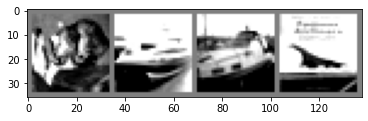

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = model(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 84 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 95 %
Accuracy of  bird : 73 %
Accuracy of   cat : 66 %
Accuracy of  deer : 82 %
Accuracy of   dog : 74 %
Accuracy of  frog : 89 %
Accuracy of horse : 89 %
Accuracy of  ship : 91 %
Accuracy of truck : 90 %


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def buildConvLayer(in_channels, out_channels, kernel_size = 3, padding = 0, bias = False, activation = nn.ReLU ,normalization = None, group_count = 2, dropout = None, stride = 1, groups=1):
    
    conv_layer = []

    conv_layer.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,padding=padding, bias=bias, stride = stride, groups = groups ))
    conv_layer.append(activation())

    if normalization:
        if "BN" == normalization:
            conv_layer.append(nn.BatchNorm2d(out_channels))
        if "GN" == normalization:
            conv_layer.append(nn.GroupNorm(group_count,out_channels))
        if "LN" == normalization:
            conv_layer.append(nn.GroupNorm(1,out_channels))

    if dropout:
        conv_layer.append(nn.Dropout(dropout))
    
    return conv_layer
      

def buildConvBlock(in_channels, out_channels_list, kernel_size = 3, padding = 0, bias = False, activation = nn.ReLU ,normalization = None, group_count = 2, dropout = None, dropout_layers = 'last', stride=1, groups = 1):
    conv_block = []
    dropout_val = None

    if dropout and 'all' == dropout_layers:
        dropout_val = dropout

    for out_channels in out_channels_list:
        conv_block += buildConvLayer(in_channels, out_channels, kernel_size, padding, bias, activation, normalization, group_count, dropout_val, stride =stride,groups = groups)
        in_channels = out_channels

    if dropout and 'last' == dropout_layers:
        conv_block.append(nn.Dropout(dropout))

    return nn.Sequential(*conv_block)


def buildTransBlock(in_channels, out_channels):
    trans_block = []

    if in_channels != out_channels:
        trans_block.append(buildConvLayer(in_channels, out_channels, kernel_size=1))

    trans_block.append(nn.AvgPool2d(4))

    return nn.Sequential(*trans_block)
     


class Net(nn.Module):
    def __init__(self, **kwargs):
        super(Net, self).__init__()
        

        self.conv1 = buildConvBlock(3,[32,32,32], padding = 1, dropout=0.1, **kwargs)
        self.trans1 = buildConvBlock(32,[32], padding = 1, stride = 2, **kwargs) #strided convolution

        self.conv2 = buildConvBlock(32,[32,32],padding = 1, dropout=0.1, **kwargs)
        self.trans2 = buildConvBlock(32,[32], padding = 1, stride = 2, **kwargs) #strided convolution
        
        self.conv3 = buildConvBlock(32,[32,32],padding = 1, dropout=0.1, **kwargs)
        self.trans3 = buildConvBlock(32,[32], padding = 1, stride = 2, **kwargs) #strided convolution

        self.conv4 = buildConvBlock(32,[32,32],padding = 1, dropout=0.1, **kwargs)
        self.trans4 = buildTransBlock(32,32) # Average pooling

        self.layers = [self.conv1, self.trans1, self.conv2, self.trans2, self.conv3, self.trans3, self.conv4, self.trans4]       
        self.fc = nn.Linear(10*3*3,10)

    def forward(self, x):
        for f in self.layers:
          x = f(x)
        #x = x.view(x.size(0),-1)
        #x = self.fc(x)
        return F.log_softmax(x,dim=1)

kwargs = {"normalization" : "BN"}
model = Net(**kwargs).to(device)  # Create model
summary(model, input_size=(3, 32, 32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,216
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 32, 32]           9,216
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 16, 16]           9,216
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
           Conv2d-14           [-1, 32,